In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

# enter your exotic-ld path if it isn't already defined in your 
# environment variables. 
os.environ['EXO_LD_PATH'] = '/Users/tylergordon/research/exotic_ld_data'

from fit import fit_wlc, fit_spec
from plot_utils import get_wl_models 
from distributions import *
import sys_params

In [2]:
# define priors for the planet's parameters. Use the 
# priors defined in distributions.py
priors_dict = sys_params.priors_dict['175.01']

# stellar parameters for computing priors 
# on the limb-darkening coefficients
st_params_dict = sys_params.stellar_params_dict['175.01']

# load all the data.
def load_all(base_dir, prefix):

    time = np.load(base_dir + prefix + '_times.npy')
    time_offset = time[0]
    time -= time[0]
    spec = np.load(base_dir + prefix + '.npy')
    cube = np.load(base_dir + prefix + '_cleaned_cube.npy')
    wavs = np.load(base_dir + prefix + '_wav.npy')

    return time, wavs, spec, cube, time_offset

In [3]:
# fit the white light curve. This returns a result 
# dictionary, which can be passed directly to the 
# spectral fitting function in the next step. 
# Most of the inputs here are self-explanatory, 
# except for cube, which is optional but if provided 
# should be the cleaned data cube of shape 
# (N_times x N_y-pixels x N_wavelengths). 
# gp=True means use a gp model, default is False. 
# n_pca_components is the number of PCA vectors to 
# use for detrending. PCA detrending is only carried 
# out if a data cube is provided. If you don't want to 
# include PCA detrending set cube=None or n_pca_components=0. 
# You can also detrend on another set of vectors such as the 
# x and y-shifts. I commented this out because it doesn't 
# seem to do anything for this particular target, but 
# feel free to experiment. 

def fit_wrapper(opts, base_dir, prefix, detector):

    time, wavs, spec, cube, time_offset = load_all(base_dir, prefix)
    
    return fit_wlc(
        time, 
        spec, 
        wavs, 
        priors_dict, 
        st_params_dict,
        detector, 
        cube=cube,
        gp=opts[0], 
        n_pca_components=opts[1],
        samples=10000, 
        burnin=5000, 
        nproc=2,
        save_chains=False,
        return_chains=True
    )

opts = (True, 3)
results_nrs1 = fit_wrapper(
    opts, 
    '/Users/tylergordon/research/compass/targets/175.01/T1/reduction/stage3/', 
    '175.01_T1_nrs1',
    'nrs1'
)
results_nrs2 = fit_wrapper(
    opts, 
    '/Users/tylergordon/research/compass/targets/175.01/T1/reduction/stage3/', 
    '175.01_T1_nrs2',
    'nrs2'
)

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [05:20<00:00, 31.22it/s]


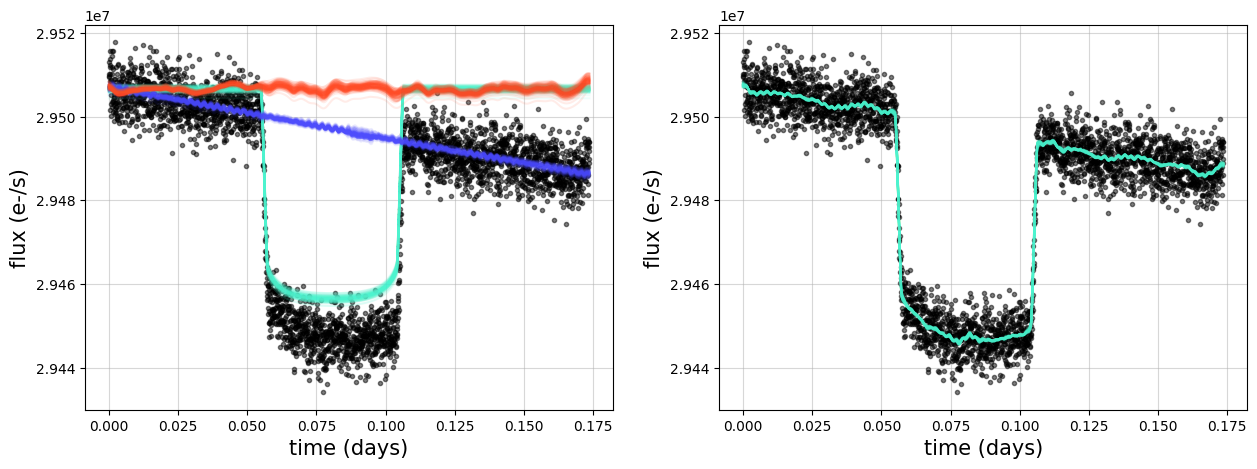

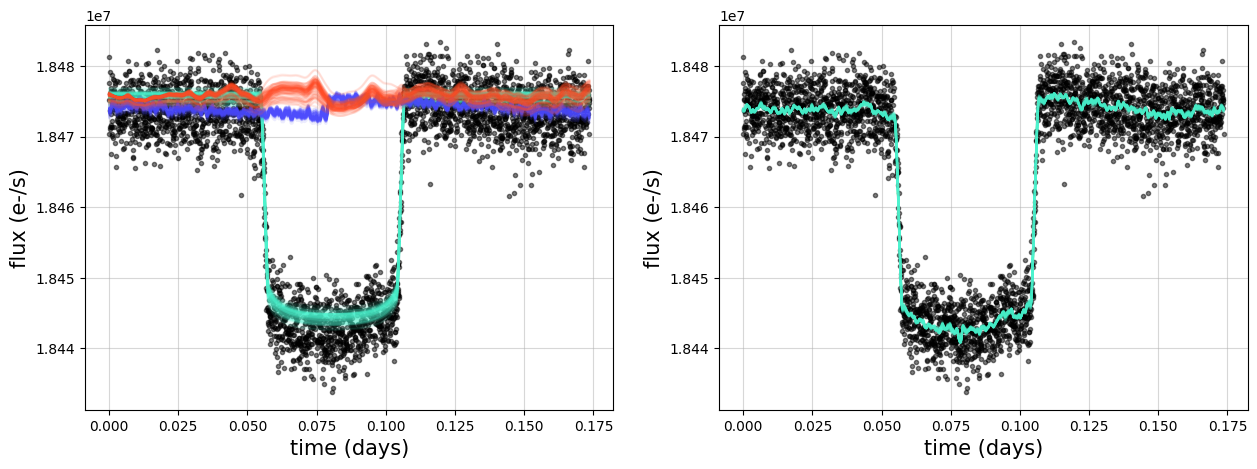

In [4]:
# Plot the results from fitting the white light curve. The first plot 
# separates the components of the fit into the gp (if gp=True above), 
# transit model, and systematics model. The second plot shows the sum of 
# all the components. 

for result in [results_nrs1, results_nrs2]:

    time = result['time']
    if result['gp']:
        trans, sys, pred, f = get_wl_models(result, nsamples=100)
    else:
        trans, sys, f = get_wl_models(result, nsamples=100)
    
    color_inds = (0.4, 0.1, 0.9)
    colors = [plt.cm.rainbow(i) for i in color_inds]
    
    flux = np.sum(result['spec'], axis=1)[~result['mask']]
    masked_time = time[~result['mask']]
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(masked_time, flux, '.', color='k', alpha=0.5)
    axs[0].plot(masked_time, trans.T, color=colors[0], alpha=0.1);
    axs[0].plot(masked_time, sys.T + f, color=colors[1], alpha=0.1);
    
    if result['gp']:
        axs[0].plot(masked_time, pred.T + f, color=colors[2], alpha=0.1);
    
    axs[1].plot(masked_time, flux, '.', color='k', alpha=0.5)
    
    if result['gp']:
        axs[1].plot(masked_time, trans.T + sys.T + pred.T, color=colors[0], alpha=0.1);
    else:
        axs[1].plot(masked_time, trans.T + sys.T, color=colors[0], alpha=0.1);
    
    [ax.grid(alpha=0.5) for ax in axs];
    [ax.set_xlabel('time (days)', fontsize=15) for ax in axs];
    [ax.set_ylabel('flux (e-/s)', fontsize=15) for ax in axs];

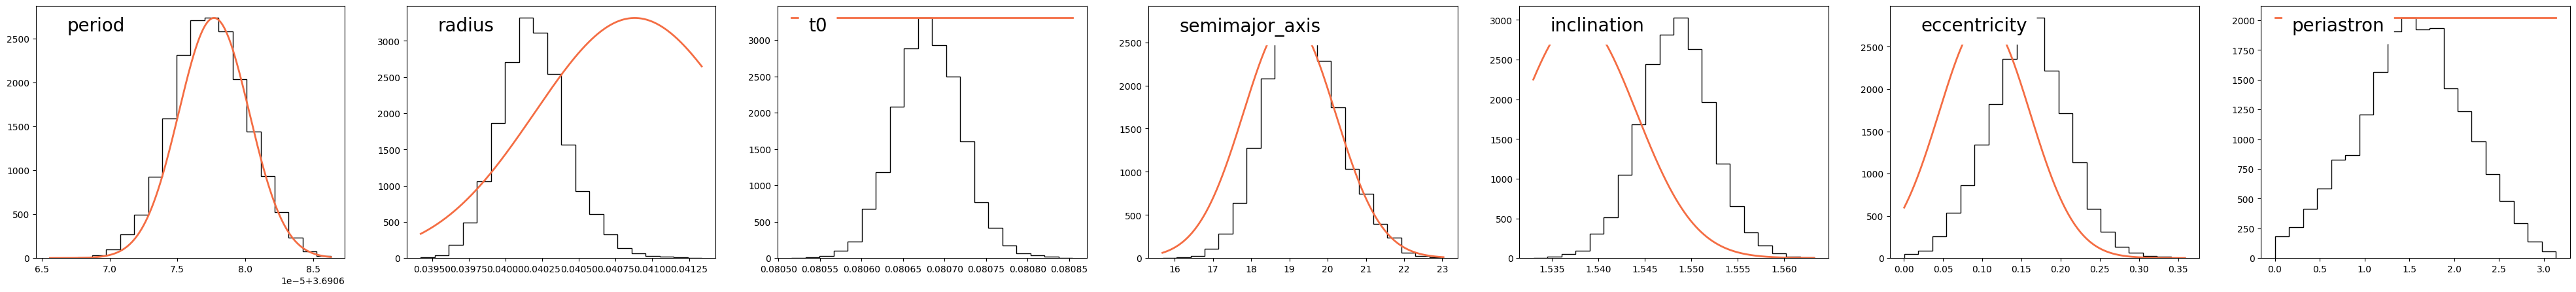

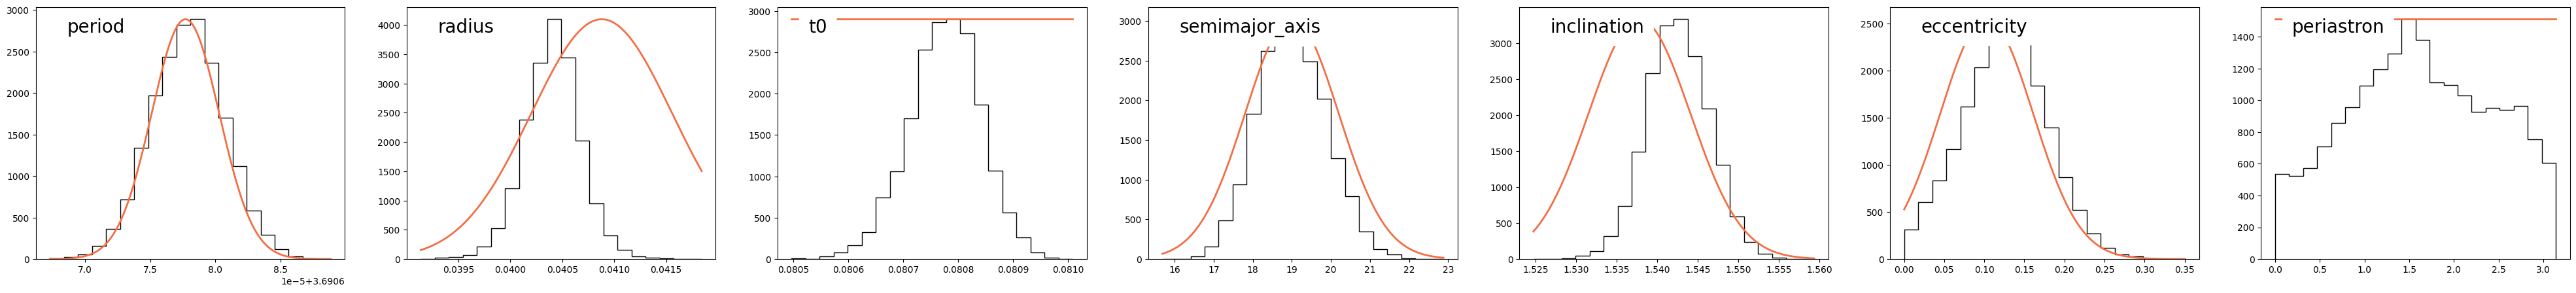

In [5]:
from plot_utils import get_canonical_params

pnames = ['period', 'radius', 't0', 'semimajor_axis', 'inclination', 'eccentricity', 'periastron']

for result in [results_nrs1, results_nrs2]:
    
    p = get_canonical_params(result, 1)
    
    fig, axs = plt.subplots(1, len(p), figsize=(50, 5))
    for i, (name, param) in enumerate(zip(pnames, p)):
        
        x = np.linspace(param.min(), param.max(), 1000)
        heights, bins = np.histogram(param.flatten(), bins=20)
        
        axs[i].hist(
            param.flatten(), 
            histtype='step', 
            bins=20, 
            color='k', 
            linewidth=1
        )
        axs[i].plot(
            x, 
            np.exp(
                np.vectorize(priors_dict[name].prior)(x)
            ) * heights.max(), 
            color=plt.cm.Spectral(0.2), 
            linewidth=2
        )
        axs[i].annotate(
            name, 
            xy=(0.1, 0.9), 
            xycoords='axes fraction',
            fontsize=20,
            bbox=dict(facecolor='w', edgecolor='w', pad=0.5, boxstyle='round')
        )

In [6]:
# fit the spectral light curves. The options 
# here are also pretty self-explanatory, except 
# for n_pca_components_spec, which allows you 
# to specify how many wavelength-dependent 
# PCA vectors you want to use in the fitting. 
# this is similar to n_pca_components above, 
# except the PCA is done on the pixels at and 
# near the wavelength bin rather than from 
# the whole data cube. If n_pca_components is 
# not specified, then the PCA vectors 
# from the white light curve fitting are 
# also used for detrending. If you don't want 
# to use those vectors, then set n_pca_components 
# to zero here. As above, you can also include additional 
# vectors for detrending by passing an argument for 
# detrending_vectors. 
fit_spec_wrapper = lambda result: fit_spec(
    result,
    wav_per_bin=0.02, 
    samples=10000, 
    burnin=5000, 
    nproc=12, 
    n_pca_components_spec=0,
    save_chains=False,
    return_chains=True,
    gp=False
)

chains_nrs1, wavs_nrs1 = fit_spec_wrapper(results_nrs1)
chains_nrs2, wavs_nrs2 = fit_spec_wrapper(results_nrs2)

running bands 61-67 of 67                                   

[None, None]

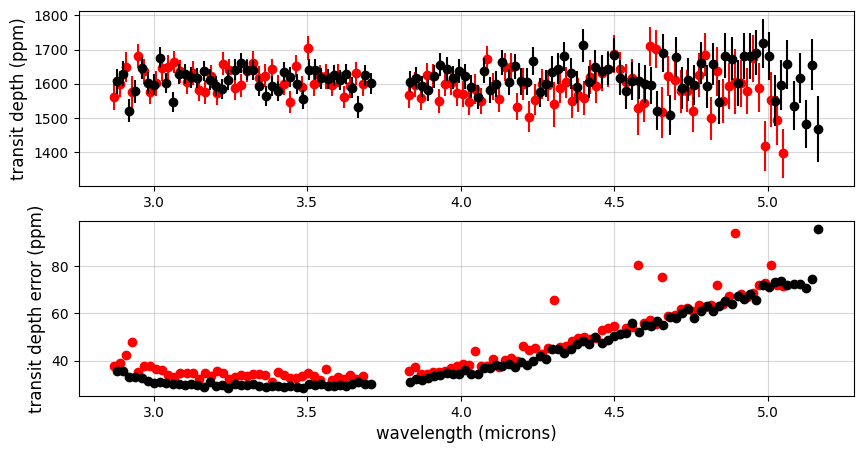

In [9]:
# plot the spectrum! 
from astropy.io import ascii

nw = ascii.read('other_spectra/NW_' + '175.01' + '_' + 'T1' + '.csv')
wav_nw = nw['Wavelength(microns)']
dep_nw = nw['(Rp/R*)^2']
err_nw = nw['Error']

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    
axs[0].plot(wav_nw, dep_nw * 1e6, 'ro')
axs[0].errorbar(wav_nw, dep_nw * 1e6, yerr=err_nw * 1e6, color='r', ls='none')
axs[1].plot(wav_nw, err_nw * 1e6, 'ro')

#fig, axs = plt.subplots(2, 1, figsize=(10, 5))
for bin_wavs, chains in zip([wavs_nrs1, wavs_nrs2], [chains_nrs1, chains_nrs2]):

    rp = np.array([np.mean(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chains])
    err = np.array([np.std(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chains])
    
    dep = rp**2 * 1e6
    dep_err = 2 * rp * err * 1e6
    
    axs[0].plot(bin_wavs, dep, 'ko')
    axs[0].errorbar(bin_wavs, dep, yerr=dep_err, color='k', ls='none')
    
    axs[1].plot(bin_wavs, dep_err, 'ko')
    
axs[0].set_ylabel('transit depth (ppm)', fontsize=12)

axs[1].set_ylabel('transit depth error (ppm)', fontsize=12)
axs[1].set_xlabel('wavelength (microns)', fontsize=12)
[ax.grid(alpha=0.5) for ax in axs]